<a href="https://colab.research.google.com/github/smBello-tse/CIFAR10-classification/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [135]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import torch
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from time import time
from torch.utils.data import default_collate
from torchvision.transforms import v2
root = '/kaggle/input'

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [136]:
torch.manual_seed(42)

## **I. Data Pre-processing**



In [137]:
#Loading dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
val_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
val_dataset, _ = torch.utils.data.random_split(val_test_dataset, [0.5, 0.5])

Label is: 3
Image shape: torch.Size([3, 32, 32])


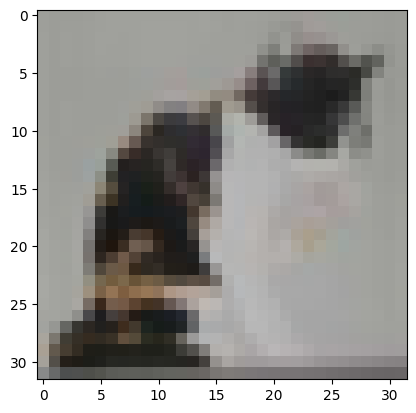

In [138]:
#Visualisation
image, target = train_dataset[785]
print(f"Label is: {target}")
print(f"Image shape: {image.shape}")
image = image.permute(1,2,0).numpy()
plt.imshow(image, cmap="gray")
plt.show()

In [139]:
def compute_mean_std_dataset(dataset):
  imgs = [item[0] for item in train_dataset] # item[0] and item[1] are image and its label
  imgs = torch.stack(imgs, dim=0).numpy()

# calculate mean over each channel (r,g,b)
  mean_r = imgs[:,0,:,:].mean()
  mean_g = imgs[:,1,:,:].mean()
  mean_b = imgs[:,2,:,:].mean()
  means = (mean_r,mean_g,mean_b)

# calculate std over each channel (r,g,b)
  std_r = imgs[:,0,:,:].std()
  std_g = imgs[:,1,:,:].std()
  std_b = imgs[:,2,:,:].std()
  stds = (std_r,std_g,std_b)
  return means, stds

means_train, stds_train = compute_mean_std_dataset(train_dataset)
means_val, stds_val = compute_mean_std_dataset(val_dataset)

In [140]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(means_train, stds_train), transforms.RandomRotation(degrees=(-40, 40)), transforms.RandomHorizontalFlip()])
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(means_val, stds_val)])
val_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
val_dataset, _ = torch.utils.data.random_split(val_test_dataset, [0.5, 0.5])

In [141]:
#Creating dataloader
NUM_CLASSES = 10
cutmix = v2.CutMix(num_classes=NUM_CLASSES)
mixup = v2.MixUp(num_classes=NUM_CLASSES)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])
def collate_fn(batch):
  return cutmix_or_mixup(*default_collate(batch))
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# **II. Model implementation**

In [142]:
class Conv_layer(torch.nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=3, stride=None, padding=None):
    super().__init__()
    self.stride = 1 if stride is None else stride
    self.padding = 0 if padding is None else padding
    self.conv_layer = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, self.stride, self.padding),
                                          torch.nn.MaxPool2d(kernel_size=2),
                                          torch.nn.LeakyReLU())


  def forward(self, x):
    return self.conv_layer(x)

In [143]:
x, _ = train_dataset[785]
x = x.unsqueeze(0)
conv_layer = Conv_layer(3, 16, 5)
feature_map = conv_layer(x)
print(feature_map.shape)

torch.Size([1, 16, 14, 14])


In [144]:
class My_CNN(torch.nn.Module):

  def __init__(self, in_channels, out_channels, conv_kernels, fc_dims, upsample=False):
    super().__init__()
    self.upsample = upsample
    self.in_channels = in_channels
    self.conv_kernels = conv_kernels
    self.fc_dims = fc_dims
    self.conv_layers = torch.nn.ModuleList([torch.nn.Sequential(Conv_layer(cin, cout, kernel), torch.nn.BatchNorm2d(num_features=cout)) for cin, cout, kernel in zip(in_channels, out_channels, conv_kernels)])
    self.fc_layers = torch.nn.ModuleList([torch.nn.Sequential(torch.nn.Linear(dim_in, dim_out), torch.nn.BatchNorm1d(num_features=dim_out, momentum=0.01), torch.nn.LeakyReLU(1e-2)) for dim_in, dim_out in zip(fc_dims[:-2], fc_dims[1:-1])])
    self.regression_head = torch.nn.Linear(fc_dims[-2], fc_dims[-1])


  def forward(self, x):
    if self.upsample:
      x = torch.nn.Upsample(scale_factor=2)(x)
    for conv_layer in self.conv_layers:
      x = conv_layer(x)
    #print(f"x shape is {x.shape}")
    x = x.view(x.size(0), -1)
    for fc_layer in self.fc_layers:
      x = fc_layer(x)
    return self.regression_head(x)


# **III. Training and test**

In [145]:
def compute_Hf_Wf(conv_kernels, Hi, Wi):
    '''Computes the height and width of the output of the final convolutional layer. This function assumes a maxpool2D of kernel 2x2, as well as default stride(1), padding(0) and dilation(0) for both pooling and convolution.
    Parameters:
        * conv_kernels: a list or tuple of the kernels of the successive convolutional layers
        * Hi: Initial height
        * Wi: Initial width

    Outputs:
        * Hf: final height
        * Wf: final width
    '''

    Hf, Wf = Hi, Wi
    for k in conv_kernels:
      Hf = (Hf - (k - 1)) // 2
      Wf = (Wf - (k - 1)) // 2
    return Hf, Wf


conv_kernels, Hi, Wi = (5,3,3), 32, 32
Hf, Wf = compute_Hf_Wf(conv_kernels, Hi, Wi)
print(Hf, Wf)

2 2


In [146]:
print(Hf)

2


In [147]:
def init_weights(m):
  if isinstance(m, torch.nn.Linear):
    torch.nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
    if m.bias is not None:
      torch.nn.init.constant_(m.bias, 0)

In [148]:
image = train_dataset[785][0]
C, H, W = image.shape
nb_classes = 10
in_channels = (C, 64, 128, 256)
out_channels = (64, 128, 256, 512)
conv_kernels = (5, 3, 3, 3)
upsample = True
if upsample: H, W = H*2, W*2
Hf, Wf = compute_Hf_Wf(conv_kernels, H, W)
fc_dims = (out_channels[-1]*Hf*Wf, 512, 256, 128, nb_classes)
model = My_CNN(in_channels, out_channels, conv_kernels, fc_dims, upsample=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.apply(init_weights)

My_CNN(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv_layer(
        (conv_layer): Sequential(
          (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
          (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (2): LeakyReLU(negative_slope=0.01)
        )
      )
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv_layer(
        (conv_layer): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
          (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (2): LeakyReLU(negative_slope=0.01)
        )
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv_layer(
        (conv_layer): Sequential(
          (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
          (1): MaxPool2d(kern

In [149]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")
print(f"Device is {device}")

Number of parameters: 2772362
Device is cuda


In [150]:
print(model.parameters)

<bound method Module.parameters of My_CNN(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv_layer(
        (conv_layer): Sequential(
          (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
          (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (2): LeakyReLU(negative_slope=0.01)
        )
      )
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv_layer(
        (conv_layer): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
          (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (2): LeakyReLU(negative_slope=0.01)
        )
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv_layer(
        (conv_layer): Sequential(
          (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1

In [151]:
if device=="cuda": model = torch.compile(model)

In [152]:
optimizer = None #Just so that I can resume training

In [153]:
#Training and validation
nb_epochs = 150
if optimizer is None: optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
else: print(optimizer)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
losses_train, losses_val = [], []
best_loss = 1e5
lr_decay = 0.99
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)
torch.set_float32_matmul_precision('high')

model.train()

for epoch in range(nb_epochs):
  start = time()
  print(f"Epoch: {epoch}")
  #print("Now training...")
  loss_train, loss_val = 0, 0
  for idx, (batch, target) in tqdm(enumerate(train_loader)):
    batch, target = batch.to(device), target.to(device)
    optimizer.zero_grad()
    #with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
    preds = model(batch)
    #print(preds.shape, preds.dtype)
    #print(target.shape, target.dtype)
    loss = criterion(preds, target)
    loss.backward()
    loss_train += loss.item()
    optimizer.step()
  loss_train /= len(train_loader)
  losses_train.append(loss_train)
  scheduler.step()


  #print("Now validation...")
  with torch.no_grad():
    for idx, (batch, target) in tqdm(enumerate(val_loader)):
      batch, target = batch.to(device), target.to(device)
      preds = model(batch)
      #print(preds.shape, preds.dtype)
      #print(target.shape, target.dtype)
      loss = criterion(preds, target)
      loss_val += loss.item()
    loss_val /= len(val_loader)
    if loss_val < best_loss:
      best_loss = loss_val
      best_model, best_epoch = model, epoch
    losses_val.append(loss_val)

  print(f"Loss_train: {loss_train:.4f} and loss_val: {loss_val:.4f}")
end = time()
#Loss_train: 1.9613 and loss_val: 1.4909

Epoch: 0


391it [00:55,  7.00it/s]
40it [00:01, 25.49it/s]

Loss_train: 1.9949 and loss_val: 1.4992


Time elapsed: 57.47294855117798
Seconds per epoch: 57.47294855117798
Best epoch: 0
Best loss: 1.4992


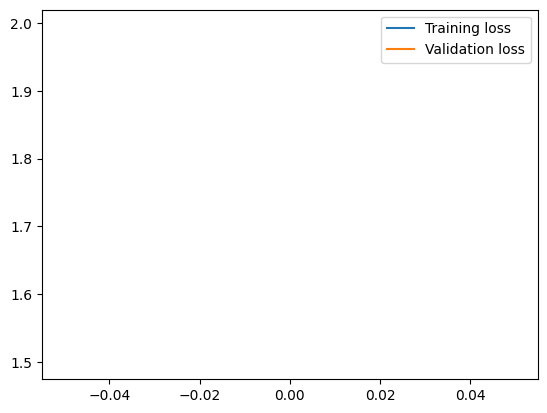

In [154]:
time_elapsed = end- start
print(f"Time elapsed: {time_elapsed}")
print(f"Seconds per epoch: {time_elapsed / nb_epochs}")
print(f"Best epoch: {best_epoch}")
print(f"Best loss: {best_loss:.4f}")

epochs = range(nb_epochs)

plt.plot(epochs, losses_train, label="Training loss")
plt.plot(epochs, losses_val, label="Validation loss")
plt.legend()
plt.show()

In [155]:
#Test on val data
best_model.eval()
print("Now testing...")
loss_test = 0
test_batch = next(iter(val_loader))
all_preds = []
all_targets = []
probabilities = []
with torch.no_grad():
  for idx, (batch, target) in tqdm(enumerate(val_loader)):
      batch, target = batch.to(device), target.to(device)
      preds = best_model(batch)
      loss = criterion(preds, target)
      loss_test += loss.item()
      all_preds.append(torch.argmax(preds, dim=-1).cpu().numpy())
      all_targets.append(target.cpu().numpy())
      probabilities.append(torch.softmax(preds, dim=-1).cpu().numpy())
  all_preds = np.concatenate(all_preds)
  all_targets = np.concatenate(all_targets)
  probabilities = np.concatenate(probabilities)
  loss_test /= len(val_loader)

  print(f"Loss_test: {loss_test:.4f}")

Now testing...


40it [00:01, 20.12it/s]

Loss_test: 1.4711


In [156]:
print(probabilities.shape)
avg_max_probability = np.mean(np.max(probabilities, axis=-1))
avg_min_probability = np.mean(np.min(probabilities, axis=-1))
print(f"Average max probability: {avg_max_probability:.4f}")
print(f"Average min probability: {avg_min_probability:.4f}")

(5000, 10)
Average max probability: 0.4010
Average min probability: 0.0210


In [157]:
pred_probabilities = np.zeros((all_targets.shape[0], ))
for i in range(all_targets.shape[0]):
  pred_probabilities[i] = probabilities[i, all_preds[i]]

avg_max_pred_probability = np.max(pred_probabilities, axis=0)
avg_min_pred_probability = np.min(pred_probabilities, axis=0)
print(f"Average max predicted probability: {avg_max_pred_probability:.4f}")
print(f"Average min predicted probability: {avg_min_pred_probability:.4f}")

avg_pred_probability = np.mean(pred_probabilities)
print(f"Average predicted probability: {avg_pred_probability:.4f}")

stds_pred_probability = np.std(pred_probabilities)
print(f"Standard deviation of predicted probability: {stds_pred_probability:.4f}")

Average max predicted probability: 0.9483
Average min predicted probability: 0.1282
Average predicted probability: 0.4010
Standard deviation of predicted probability: 0.1674


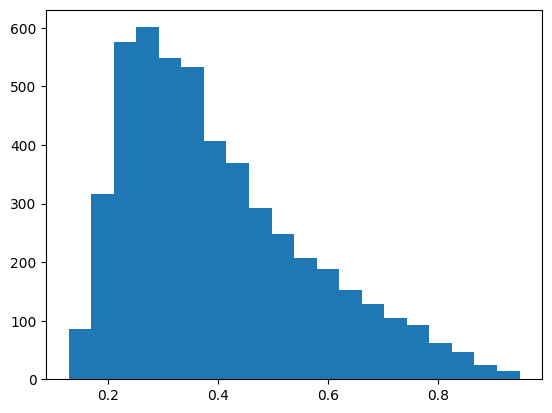

In [158]:
plt.hist(pred_probabilities, bins=20)
plt.show()

(2130,)


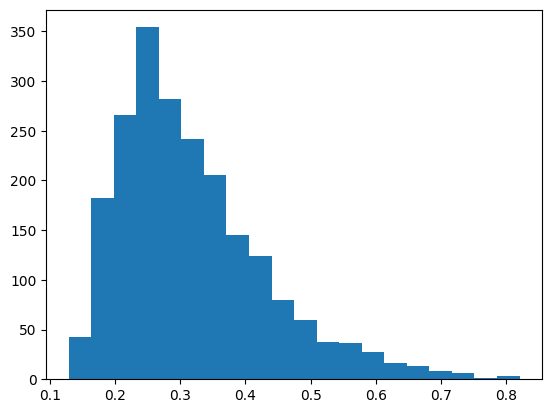

In [159]:
wrong_pred_probability = []
for i in range(all_targets.shape[0]):
  if all_preds[i] != all_targets[i]:
    wrong_pred_probability.append(probabilities[i, all_preds[i]])
wrong_pred_probability = np.array(wrong_pred_probability)
print(wrong_pred_probability.shape)
plt.hist(wrong_pred_probability, bins=20)
plt.show()

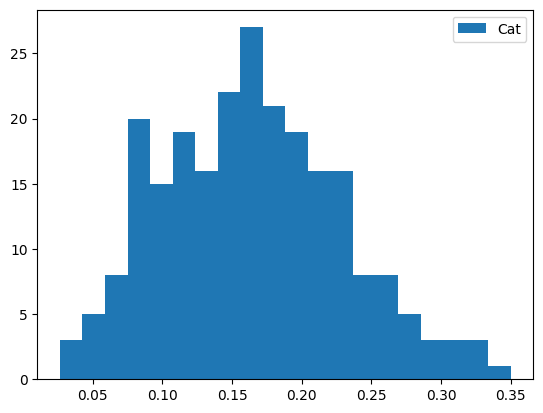

In [160]:
wrong_cat_probability = []
for i in range(all_targets.shape[0]):
  if all_preds[i] != all_targets[i] and all_targets[i]==3:
    wrong_cat_probability.append([probabilities[i, 3], probabilities[i, 5]])
wrong_cat_probability = np.array(wrong_cat_probability)
plt.hist(wrong_cat_probability[:,0], bins=20, label="Cat")
plt.legend()

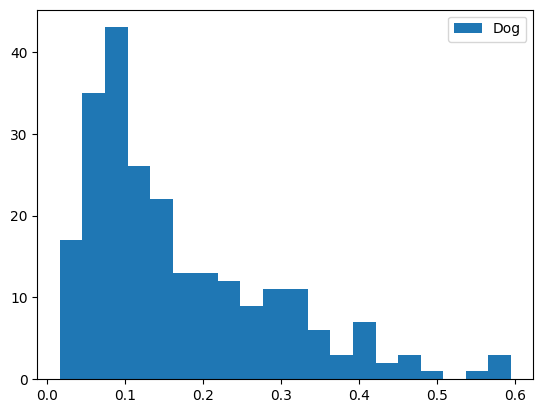

In [161]:
plt.hist(wrong_cat_probability[:,1], bins=20, label="Dog")
plt.legend()

Average probability: 0.3394
Standard deviation: 0.0906


(array([ 5.,  9., 14., 19., 28., 30., 29., 23., 25., 23., 21.,  9.,  7.,
         6.,  3.,  0.,  4.,  1.,  1.,  1.]),
 array([0.15739067, 0.18277191, 0.20815316, 0.2335344 , 0.25891563,
        0.28429687, 0.30967814, 0.33505937, 0.36044061, 0.38582185,
        0.41120309, 0.43658435, 0.46196556, 0.48734683, 0.5127281 ,
        0.5381093 , 0.56349057, 0.58887178, 0.61425304, 0.63963431,
        0.66501552]),
 <BarContainer object of 20 artists>)

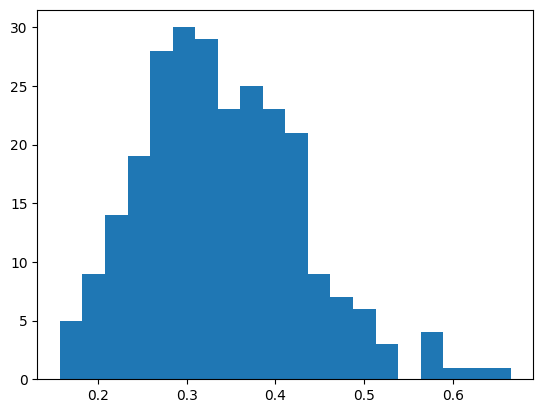

In [162]:
good_cat_probability = []
for i in range(all_targets.shape[0]):
  if all_preds[i] == all_targets[i] and all_targets[i]==3:
    good_cat_probability.append(probabilities[i, all_preds[i]])
good_cat_probability = np.array(good_cat_probability)
print(f"Average probability: {np.mean(good_cat_probability):.4f}")
print(f"Standard deviation: {np.std(good_cat_probability):.4f}")
plt.hist(good_cat_probability, bins=20)

In [163]:
true_label_probabilities = np.zeros((all_targets.shape[0], 1))
for i in range(all_targets.shape[0]):
  true_label_probabilities[i] = probabilities[i, all_targets[i]]
print(all_targets[:5])
print(probabilities[:5])
print(true_label_probabilities[:5])
print(true_label_probabilities.shape)

[7 1 7 1 2]
[[0.02939343 0.02786301 0.18933026 0.19989528 0.16135113 0.19535731
  0.05478522 0.10490723 0.0236527  0.01346447]
 [0.07668201 0.5117346  0.07214991 0.02479518 0.04111748 0.01832025
  0.12615272 0.02518762 0.05217746 0.05168274]
 [0.02794486 0.03354787 0.08174009 0.08885743 0.0732082  0.25653353
  0.02667618 0.34362605 0.01890405 0.04896174]
 [0.04014476 0.6001629  0.04726816 0.02421432 0.04759219 0.02771578
  0.0491539  0.02196851 0.03238103 0.10939842]
 [0.04783676 0.03121485 0.10638989 0.07310985 0.17613268 0.08385699
  0.04345252 0.27750874 0.04966544 0.11083225]]
[[0.10490723]
 [0.5117346 ]
 [0.34362605]
 [0.60016292]
 [0.10638989]]
(5000, 1)


<Axes: >

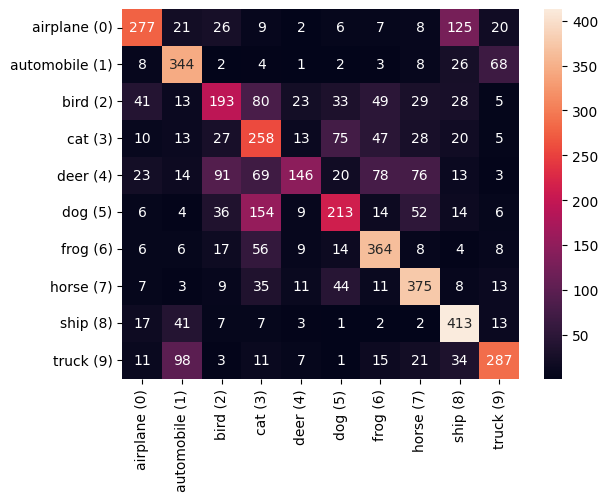

In [164]:
labels = ["airplane (0)", "automobile (1)", "bird (2)", "cat (3)", "deer (4)", "dog (5)", "frog (6)", "horse (7)", "ship (8)", "truck (9)"]
#
cm = confusion_matrix(all_targets, all_preds, labels=range(10))
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(cm_df, annot=True, fmt="d")

In [165]:
print(f"Accuracy score is: {accuracy_score(all_targets, all_preds)}")

Accuracy score is: 0.574


In [166]:
def accuracy_multi_class(y_true, y_pred, cm):
  '''
  y_true: true labels
  y_pred: predicted labels
  cm: confusion matrix

  return list of accuracies for each classes
  '''
  accuracies = np.zeros((cm.shape[0],))
  for i in range(cm.shape[0]):
    accuracies[i] = cm[i,i] / np.sum(cm[i,:])
  return accuracies

accuracies = accuracy_multi_class(all_targets, all_preds, cm)
accuracies_df = pd.DataFrame(accuracies, index=labels, columns=["Accuracy"])
accuracies_df = accuracies_df.sort_values(by="Accuracy", ascending=False)
print(accuracies_df)
print("Mean of accuracies: ", accuracies_df["Accuracy"].mean())

                Accuracy
ship (8)        0.816206
frog (6)        0.739837
automobile (1)  0.738197
horse (7)       0.726744
truck (9)       0.588115
airplane (0)    0.552894
cat (3)         0.520161
dog (5)         0.419291
bird (2)        0.390688
deer (4)        0.273921
Mean of accuracies:  0.5766055597350283


In [167]:
checkpoint = {
    "model": best_model.state_dict(),
    "optimizer": optimizer.state_dict(),
    "best_loss": best_loss,
    "epoch": best_epoch
}

# Save to a file in the working directory
#torch.save(checkpoint, "/kaggle/working/checkpoint_LeakyReLU_dropout.pth")